In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
!pip install datasets
print()

In [3]:
import random
from typing import Callable, Iterable

import datasets
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from transformers.optimization import get_linear_schedule_with_warmup
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

import torch
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModel
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import numpy as np

Обеспечим воспроизводимость результатов

In [4]:
seed = 10

random.seed(seed)
np.random.seed(seed)

torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Датасет

In [5]:
# dataset = datasets.load_dataset("snli", split="train")
dataset = datasets.load_dataset("sentence-transformers/all-nli", "pair-class", split='train')

# there are some pairs of "premise" and "hypothesis" which haven't been
# labeled in this dataset, we will filter those out first
filtered_data = dataset.filter(lambda x: x["label"] == 0 and random.random() < 0.01)

len(dataset), dataset[0]

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Filter:   0%|          | 0/942069 [00:00<?, ? examples/s]

(942069,
 {'premise': 'A person on a horse jumps over a broken down airplane.',
  'hypothesis': 'A person is training his horse for a competition.',
  'label': 1})

Обрежем датасет, чтобы быстрее обучить модель

In [29]:
# filtered_data = []
# for data in tqdm(dataset):
#     if random.random() < 0.01:
#         filtered_data.append(data)
# len(filtered_data)

  9%|▉         | 48124/549367 [00:05<01:02, 8067.56it/s] 


KeyboardInterrupt: 

In [6]:
train_data = filtered_data[:int(len(filtered_data)*0.8)]
val_data = filtered_data[int(len(filtered_data)*0.8):]

In [7]:
model_name = "sentence-transformers/all-MiniLM-L6-v2"
# model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [12]:
%%time

MAX_LENGTH = 128

tokenized_premises_train = tokenizer(train_data['premise'],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_hypothesis_train = tokenizer(train_data["hypothesis"],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

tokenized_premises_val = tokenizer(val_data["premise"],
                               max_length=MAX_LENGTH, padding="max_length",
                               truncation=True, verbose=True)

tokenized_hypothesis_val = tokenizer(val_data["hypothesis"],
                                 max_length=MAX_LENGTH, padding="max_length",
                                 truncation=True, verbose=True)

CPU times: user 1.05 s, sys: 128 ms, total: 1.18 s
Wall time: 1.2 s


In [13]:
class SnliDataset(Dataset):
    def __init__(self, premise_tokens: dict, hypothesis_tokens: dict, labels: Iterable[str]):
        self.premise_tokens = premise_tokens
        self.hypothesis_tokens = hypothesis_tokens
        self.labels = labels
        self._init_data()

    def _init_data(self) -> None:
        self.data = []
        for pt_ids, pt_am, ht_ids, ht_am, label in zip(
            self.premise_tokens["input_ids"], self.premise_tokens["attention_mask"],
            self.hypothesis_tokens["input_ids"], self.hypothesis_tokens["attention_mask"],
            self.labels
        ):
            data = {}
            data["premise_input_ids"] = torch.tensor(pt_ids, dtype=torch.long)
            data["premise_attention_mask"] = torch.tensor(pt_am, dtype=torch.long)
            data["hypothesis_input_ids"] = torch.tensor(ht_ids, dtype=torch.long)
            data["hypothesis_attention_mask"] = torch.tensor(ht_am, dtype=torch.long)
            data["label"] = torch.tensor(label, dtype=torch.long)
            self.data.append(data)

    def __getitem__(self, ix: int) -> dict[str, torch.tensor]:
        return self.data[ix]

    def __len__(self) -> int:
        return len(self.data)

In [14]:
snli_dataset_train = SnliDataset(tokenized_premises_train, tokenized_hypothesis_train, (data["label"] for data in filtered_data))
snli_dataset_val = SnliDataset(tokenized_premises_val, tokenized_hypothesis_val, (data["label"] for data in filtered_data))

In [15]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [23]:
def mean_pool(token_embeds: torch.tensor, attention_mask: torch.tensor) -> torch.tensor:
    in_mask = attention_mask.unsqueeze(-1).expand(token_embeds.size()).float()
    pool = torch.sum(token_embeds * in_mask, 1) / torch.clamp(in_mask.sum(1), min=1e-9)
    return pool


def encode(input_texts: list[str], tokenizer: AutoTokenizer, model: AutoModel, device: str = "cpu"
) -> torch.tensor:

    model.eval()
    tokenized_texts = tokenizer(input_texts, max_length=128,
                                padding='max_length', truncation=True, return_tensors="pt")
    token_embeds = model(tokenized_texts["input_ids"].to(device),
                         tokenized_texts["attention_mask"].to(device)).last_hidden_state
    pooled_embeds = mean_pool(token_embeds, tokenized_texts["attention_mask"].to(device))
    return pooled_embeds

class BiEncoder(torch.nn.Module):
    def __init__(self, max_length: int = 128):
        super().__init__()
        self.max_length = max_length
        self.bert_model = AutoModel.from_pretrained(model_name)
        # self.bert_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-uncased')
        self.linear = torch.nn.Linear(self.bert_model.config.hidden_size * 3, 3)

    def forward(self, data: datasets.arrow_dataset.Dataset) -> torch.tensor:
        premise_input_ids = data["premise_input_ids"].to(device)
        premise_attention_mask = data["premise_attention_mask"].to(device)
        hypothesis_input_ids = data["hypothesis_input_ids"].to(device)
        hypothesis_attention_mask = data["hypothesis_attention_mask"].to(device)

        out_premise = self.bert_model(premise_input_ids, premise_attention_mask)
        out_hypothesis = self.bert_model(hypothesis_input_ids, hypothesis_attention_mask)
        premise_embeds = out_premise.last_hidden_state
        hypothesis_embeds = out_hypothesis.last_hidden_state

        pooled_premise_embeds = mean_pool(premise_embeds, premise_attention_mask)
        pooled_hypotheses_embeds = mean_pool(hypothesis_embeds, hypothesis_attention_mask)

        embeds =  torch.cat([pooled_premise_embeds, pooled_hypotheses_embeds,
                             torch.abs(pooled_premise_embeds - pooled_hypotheses_embeds)],
                            dim=-1)
        return self.linear(embeds)

# Инициализируем модель
model = BiEncoder(model_name).to(device)


In [24]:
# def contrastive_loss(query_emb, pos_emb, neg_emb, margin=1.0):
#     pos_dist = torch.norm(query_emb - pos_emb, p=2, dim=1)  # Расстояние до положительного документа
#     neg_dist = torch.norm(query_emb - neg_emb, p=2, dim=1)  # Расстояние до отрицательного документа
#     loss = torch.mean(torch.clamp(pos_dist - neg_dist + margin, min=0))  # Margin Ranking Loss
#     return loss

loss_fn = torch.nn.CrossEntropyLoss()

In [25]:
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
dataloaders = {'train': DataLoader(snli_dataset_train, batch_size=4, shuffle=True),
               'val': DataLoader(snli_dataset_val, batch_size=4, shuffle=False),
              }


In [26]:
EPOCHS = 10
train_loss = []
val_loss = []


for epoch in range(EPOCHS):
    print('Epoch {}/{}'.format(epoch + 1, EPOCHS))

    for phase in ['train', 'val']:
      if phase == 'train':
        model.train()
      else:
        model.eval()

      print('-------------')
      print(f"{phase}")

      total_loss = 0
      for batch in tqdm(dataloaders[phase]):
          optimizer.zero_grad()

          with torch.set_grad_enabled(phase == 'train'):
              yhat = model(batch)

              loss = loss_fn(yhat, batch["label"].to(device))

              # backward + optimize only if in training phase
              if phase == 'train':
                  loss.backward()
                  optimizer.step()

          total_loss += loss.item()

      if phase == 'train':
        train_loss.append(total_loss)
      else:
        val_loss.append(total_loss)

      print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1/10
-------------
train


100%|██████████| 633/633 [00:31<00:00, 20.02it/s]


Epoch 1, Loss: 18.9837
Epoch 1/10
-------------
val


100%|██████████| 159/159 [00:02<00:00, 71.55it/s]


Epoch 1, Loss: 0.1363
Epoch 2/10
-------------
train


100%|██████████| 633/633 [00:29<00:00, 21.13it/s]


Epoch 2, Loss: 0.4079
Epoch 2/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 96.66it/s]


Epoch 2, Loss: 0.0564
Epoch 3/10
-------------
train


100%|██████████| 633/633 [00:27<00:00, 23.15it/s]


Epoch 3, Loss: 0.1965
Epoch 3/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 95.19it/s]


Epoch 3, Loss: 0.0320
Epoch 4/10
-------------
train


100%|██████████| 633/633 [00:33<00:00, 18.95it/s]


Epoch 4, Loss: 0.1114
Epoch 4/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 96.76it/s]


Epoch 4, Loss: 0.0207
Epoch 5/10
-------------
train


100%|██████████| 633/633 [00:27<00:00, 23.17it/s]


Epoch 5, Loss: 0.0715
Epoch 5/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 97.24it/s]


Epoch 5, Loss: 0.0142
Epoch 6/10
-------------
train


100%|██████████| 633/633 [00:26<00:00, 23.60it/s]


Epoch 6, Loss: 0.0482
Epoch 6/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 97.16it/s]


Epoch 6, Loss: 0.0101
Epoch 7/10
-------------
train


100%|██████████| 633/633 [00:26<00:00, 23.78it/s]


Epoch 7, Loss: 0.0340
Epoch 7/10
-------------
val


100%|██████████| 159/159 [00:02<00:00, 78.17it/s]


Epoch 7, Loss: 0.0073
Epoch 8/10
-------------
train


100%|██████████| 633/633 [00:27<00:00, 23.19it/s]


Epoch 8, Loss: 0.0243
Epoch 8/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 94.11it/s]


Epoch 8, Loss: 0.0053
Epoch 9/10
-------------
train


100%|██████████| 633/633 [00:27<00:00, 23.42it/s]


Epoch 9, Loss: 0.0175
Epoch 9/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 96.87it/s]


Epoch 9, Loss: 0.0039
Epoch 10/10
-------------
train


100%|██████████| 633/633 [00:26<00:00, 23.68it/s]


Epoch 10, Loss: 0.0127
Epoch 10/10
-------------
val


100%|██████████| 159/159 [00:01<00:00, 97.40it/s]

Epoch 10, Loss: 0.0029


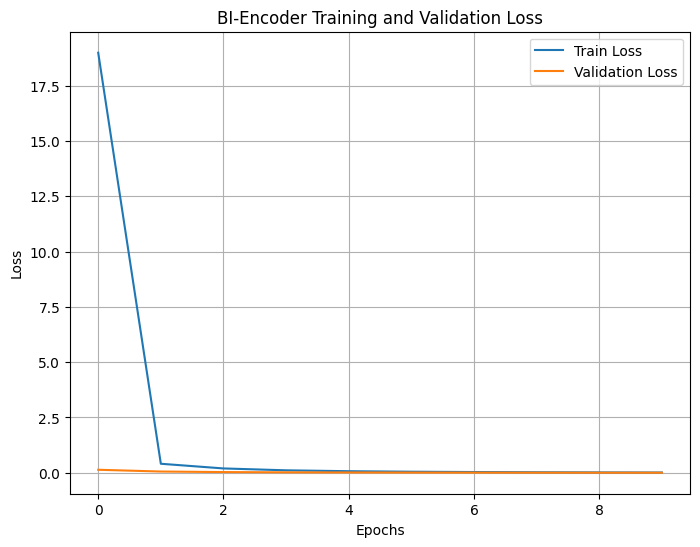

In [27]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('BI-Encoder Training and Validation Loss')
plt.legend()
plt.grid()
plt.show()


In [31]:
torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/МФТИ/генерация в NLP/ДЗ1/models/BI_model1/BI_model1.pth")